In [24]:
""" 
In this version:
1) the Diagnostic test is using 14 questions of the experiment. 
2) the order of the questions is:
        Q1
        Q4
        Q6
        Q8
        Q9omp
        Q15
        Q16
        Q17
        Q19
        Q20
        Q21
3) The dataset has 87 rows, corresponding to the 87 students that completed the diagnostic.
3) the parameters are set for 3-option questions.
"""

' \nIn this version:\n1) the Diagnostic test is using 14 questions of the experiment. \n2) the order of the questions is:\n        Q1\n        Q4\n        Q6\n        Q8\n        Q9\n        Q10\n        Q12\n        Q13\n        Q15\n        Q16\n        Q17\n        Q19\n        Q20\n        Q21\n3) The dataset has 87 subjects\n3) the parameters are set for 3-option questions.\n'

In [10]:
import pandas as pd

# Load the data
file_path = 'DiagnosticResults_14q.csv'
data = pd.read_csv(file_path, index_col=0)

# Drop the first column (subject labels) from the data
# data = data.drop(columns=data.columns[0])


# Example: Define theta as the mean response across items
data.head()

Q1  Q4  Q6  Q8  Q9  Q10  Q12  Q13  Q15  Q16  Q17  Q19  Q20  Q21
SUBJECT                                                                 
S1        1   1   0   1   1    1    0    1    1    1    0    1    1    1
S2        1   1   1   1   0    0    1    0    0    0    0    0    1    1
S3        1   1   1   1   0    0    0    1    0    1    0    0    0    0
S4        1   1   1   1   0    0    0    1    1    1    0    1    0    0
S7        1   1   1   1   0    0    1    1    1    0    0    0    0    1

In [11]:
# Define ability estimates (theta) for each student as initial guess (e.g., average score)
theta = data.mean(axis=1).values

# Assume binary response for simplicity (1 = correct, 0 = incorrect)
responses = data.values  # Convert DataFrame to numpy array for easier manipulation
print(theta)

[0.78571429 0.5        0.42857143 0.57142857 0.57142857 0.57142857
 0.57142857 0.57142857 0.35714286 0.64285714 0.64285714 0.5
 0.42857143 0.64285714 0.71428571 0.5        0.64285714 0.64285714
 0.64285714 0.42857143 0.71428571 0.35714286 0.57142857 0.42857143
 0.42857143 0.28571429 0.42857143 0.64285714 0.42857143 0.5
 0.71428571 0.5        0.64285714 0.64285714 0.5        0.28571429
 0.57142857 0.35714286 0.71428571 0.64285714 0.5        0.5
 0.64285714 0.71428571 0.42857143 0.64285714 0.71428571 0.57142857
 0.78571429 0.71428571 0.64285714 0.64285714 0.21428571 0.28571429
 0.42857143 0.57142857 0.5        0.28571429 0.57142857 0.85714286
 0.57142857 0.57142857 0.57142857 0.57142857 0.64285714 0.42857143
 0.5        0.5        0.57142857 0.71428571 0.71428571 0.5
 0.57142857 0.57142857 0.5        0.35714286 0.71428571 0.57142857
 0.42857143 0.35714286 0.71428571 0.5        0.64285714 0.64285714
 0.42857143 0.42857143 0.5       ]


In [12]:
import numpy as np
from scipy.optimize import minimize

def three_pl_model(theta, a, b, c):
    return c + (1 - c) / (1 + np.exp(-a * (theta - b)))


In [23]:
def log_likelihood(params, *args):
    theta, responses = args
    a, b, c = params
    prob = three_pl_model(theta, a, b, c)
    
    # Avoid log(0) by clipping probabilities
    prob = np.clip(prob, 1e-6, 1 - 1e-6)
    
    # Regularization to penalize large a (high discrimination)
    penalty = 0.1 * (a - 1)**2  # Penalize deviation of a from 1
    
    return -np.sum(responses * np.log(prob) + (1 - responses) * np.log(1 - prob)) + penalty


# Store the estimated parameters
item_parameters = []

for i in range(responses.shape[1]):
    initial_params = [1.0, 0.0, 0.333]  # a, b, c
    """Difficulty bounds were set to +-2.8. This was so because setting higher bounds made a difference only in 4 items (2, 3, 5 and 11). 
    The reasonably minimum bound is 2.8 because the the highest easiness below 2.8 was item 14 (2.755) """
    
    # Adding bounds to ensure valid parameter estimates
    bounds = [(0.01, 5.35),  # a: discrimination should be positive
              (-2.7, 2.7),      # b: difficulty can vary widely
              (0.25, 0.35)]  # c: guessing should be between 0 and 1

    # Optimize with bounds
    result = minimize(log_likelihood, initial_params, args=(theta, responses[:, i]), bounds=bounds)
    item_parameters.append(result.x)

# Convert to a DataFrame for easier interpretation
item_params_df = pd.DataFrame(item_parameters, columns=['a', 'b', 'c'])
item_params_df

a         b      c
0   3.445651  0.160763  0.375
1   3.512465  0.062093  0.375
2   3.140212  0.553715  0.375
3   3.919960  0.577388  0.375
4   2.343054  2.700000  0.375
5   4.609994  0.854226  0.375
6   1.618521  2.700000  0.375
7   4.179289  0.663103  0.375
8   4.415796  0.342403  0.375
9   3.046848  1.003067  0.375
10  2.290898  2.700000  0.375
11  2.060639  2.700000  0.375
12  3.999431  0.900546  0.375
13  3.983463  0.828703  0.375

In [17]:
import numpy as np

# Calculate total log-likelihood for all items
total_log_likelihood = 0

for i in range(responses.shape[1]):  # for each item
    a, b, c = item_parameters[i]
    prob = three_pl_model(theta, a, b, c)
    prob = np.clip(prob, 1e-6, 1 - 1e-6)  # Avoid log(0)
    
    # Calculate log-likelihood for this item
    item_log_likelihood = np.sum(responses[:, i] * np.log(prob) + (1 - responses[:, i]) * np.log(1 - prob))
    total_log_likelihood += item_log_likelihood

# Total number of parameters: 3 per item
num_parameters = responses.shape[1] * 3  
num_responses = responses.size  # Total number of responses (students * items)

# Calculate AIC and BIC
aic = 2 * num_parameters - 2 * total_log_likelihood
bic = np.log(num_responses) * num_parameters - 2 * total_log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

AIC: 1468.44
BIC: 1682.85


In [18]:
theta


array([0.78571429, 0.5       , 0.42857143, 0.57142857, 0.57142857,
       0.57142857, 0.57142857, 0.57142857, 0.35714286, 0.64285714,
       0.64285714, 0.5       , 0.42857143, 0.64285714, 0.71428571,
       0.5       , 0.64285714, 0.64285714, 0.64285714, 0.42857143,
       0.71428571, 0.35714286, 0.57142857, 0.42857143, 0.42857143,
       0.28571429, 0.42857143, 0.64285714, 0.42857143, 0.5       ,
       0.71428571, 0.5       , 0.64285714, 0.64285714, 0.5       ,
       0.28571429, 0.57142857, 0.35714286, 0.71428571, 0.64285714,
       0.5       , 0.5       , 0.64285714, 0.71428571, 0.42857143,
       0.64285714, 0.71428571, 0.57142857, 0.78571429, 0.71428571,
       0.64285714, 0.64285714, 0.21428571, 0.28571429, 0.42857143,
       0.57142857, 0.5       , 0.28571429, 0.57142857, 0.85714286,
       0.57142857, 0.57142857, 0.57142857, 0.57142857, 0.64285714,
       0.42857143, 0.5       , 0.5       , 0.57142857, 0.71428571,
       0.71428571, 0.5       , 0.57142857, 0.57142857, 0.5    

In [19]:
item_parameters

[array([3.43647063, 0.09402818, 0.25      ]),
 array([3.53917446, 0.00589064, 0.25      ]),
 array([3.13457744, 0.44807306, 0.25      ]),
 array([4.05103104, 0.49405992, 0.25      ]),
 array([1.35047511, 2.64304892, 0.25      ]),
 array([5.31867024, 0.71632949, 0.25      ]),
 array([1.7169991 , 1.45534733, 0.25      ]),
 array([4.28150682, 0.57124998, 0.25      ]),
 array([4.49485114, 0.29179839, 0.25      ]),
 array([3.31532549, 0.78012882, 0.25      ]),
 array([1.4660641 , 2.30876667, 0.25      ]),
 array([3.05867167, 1.19954681, 0.25      ]),
 array([4.56542571, 0.73357714, 0.25      ]),
 array([4.28054718, 0.69312075, 0.25      ])]

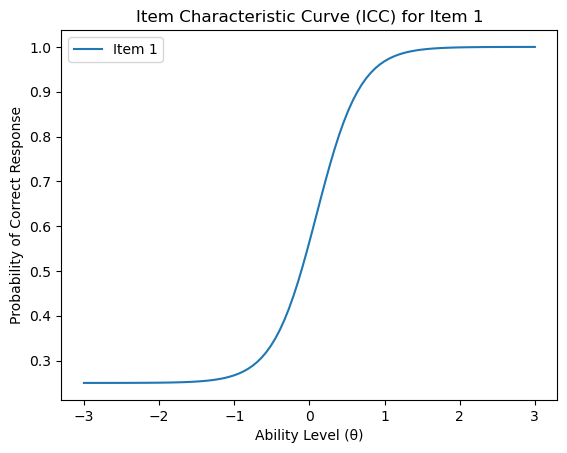

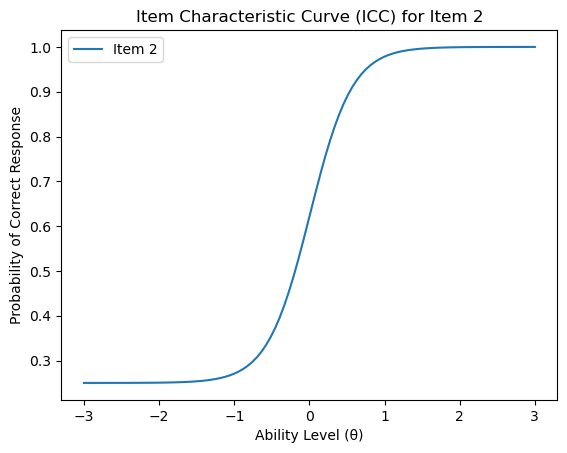

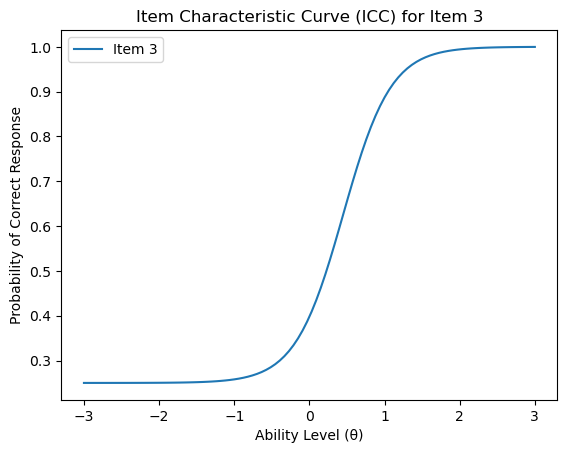

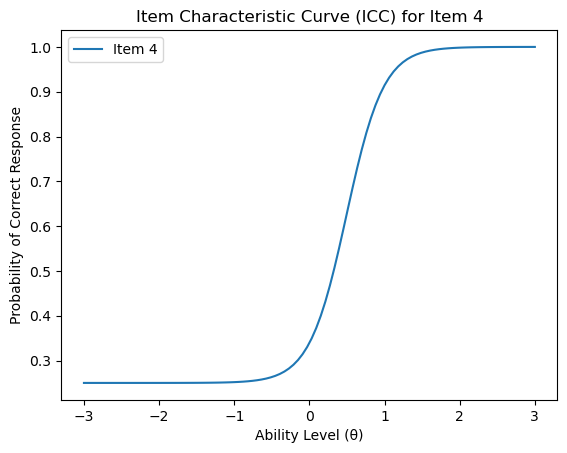

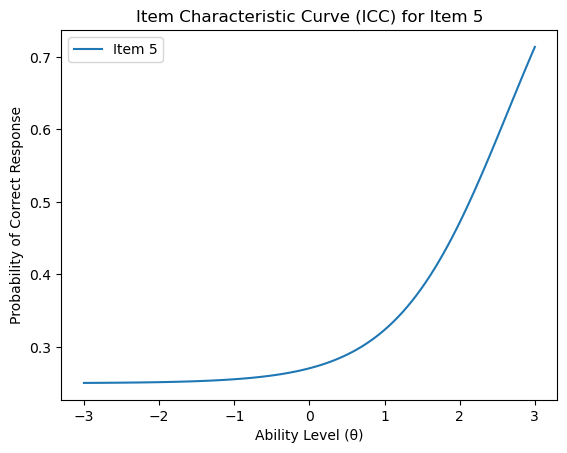

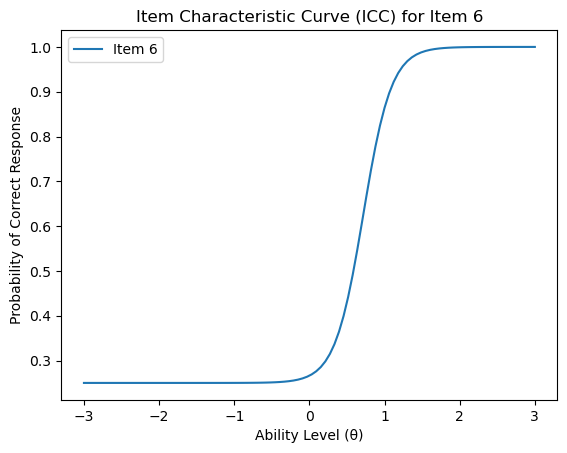

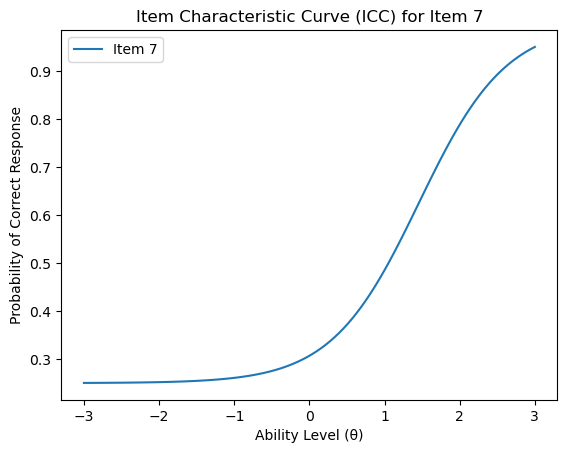

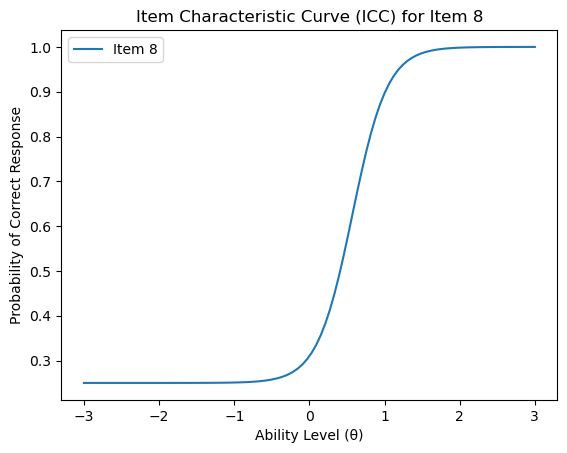

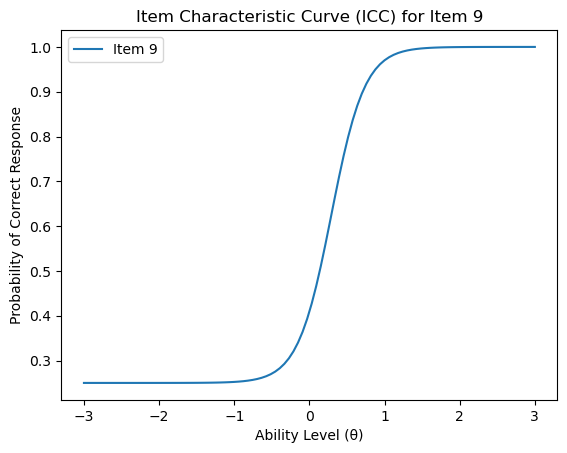

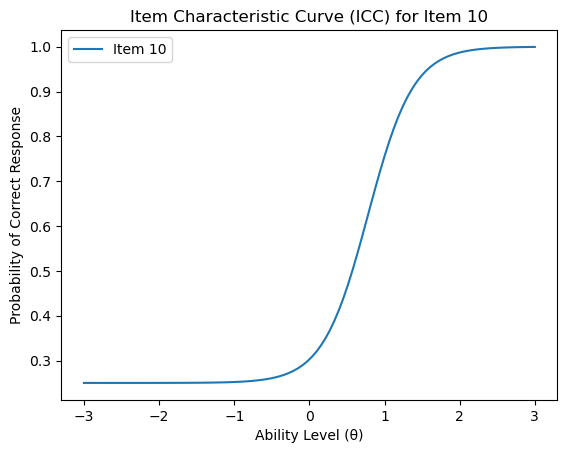

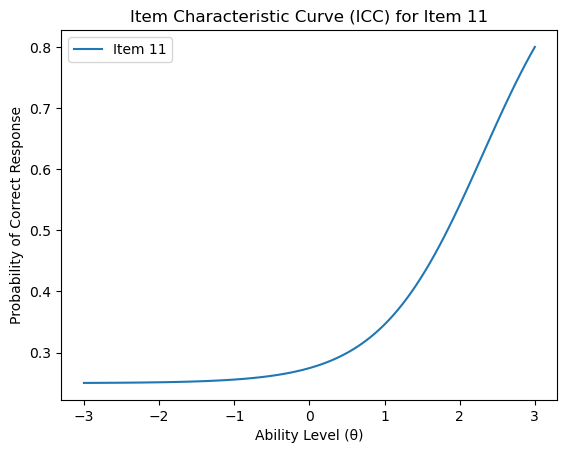

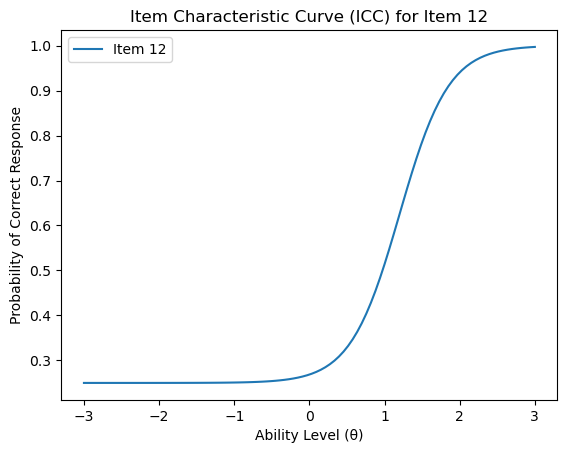

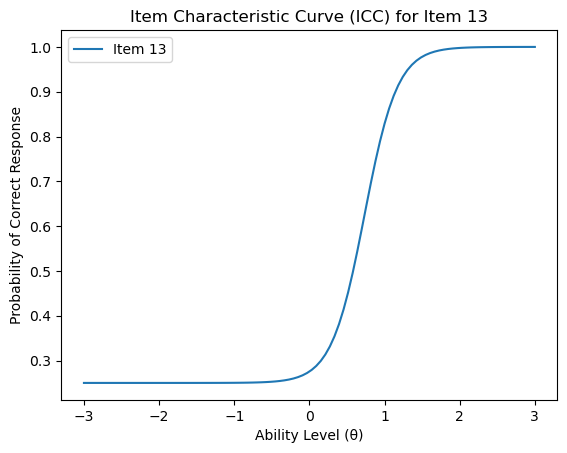

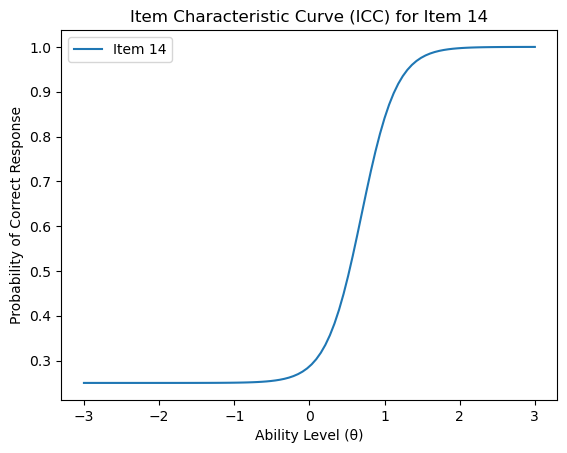

In [20]:
import matplotlib.pyplot as plt

theta_plot = np.linspace(-3, 3, 100)

# Use this theta_plot in the plotting code
for i, params in enumerate(item_parameters):
    a, b, c = params
    predicted_probabilities = three_pl_model(theta_plot, a, b, c)
    
    plt.plot(theta_plot, predicted_probabilities, label=f'Item {i+1}')
    plt.xlabel('Ability Level (θ)')
    plt.ylabel('Probability of Correct Response')
    plt.title(f'Item Characteristic Curve (ICC) for Item {i+1}')
    plt.legend()
    plt.show()


--------------- estimating ability----------------
[1 1 0 1 1 1 0 1 1 1 0 1 1 1]
[array([3.43647063, 0.09402818, 0.25      ]), array([3.53917446, 0.00589064, 0.25      ]), array([3.13457744, 0.44807306, 0.25      ]), array([4.05103104, 0.49405992, 0.25      ]), array([1.35047511, 2.64304892, 0.25      ]), array([5.31867024, 0.71632949, 0.25      ]), array([1.7169991 , 1.45534733, 0.25      ]), array([4.28150682, 0.57124998, 0.25      ]), array([4.49485114, 0.29179839, 0.25      ]), array([3.31532549, 0.78012882, 0.25      ]), array([1.4660641 , 2.30876667, 0.25      ]), array([3.05867167, 1.19954681, 0.25      ]), array([4.56542571, 0.73357714, 0.25      ]), array([4.28054718, 0.69312075, 0.25      ])]
1 3.4364706343296754 0.09402817698713163 0.25 0.5649357504655347 1.4950855175718682 2.902536772094168
1 3.539174459625193 0.005890640078598493 0.25 0.6210911410306528 2.8361100737619065 5.850309770787472
0 3.134577439691201 0.44807305734078484 0.25 0.39782491242652657 1.5890970783225886 

1 4.2805471846666965 0.693120745741454 0.25 0.29968962126060583 14.080593728974883 40.23112559176379
1 3.4364706343296754 0.09402817698713163 0.25 0.613895441483894 1.3268369771214221 2.799139944563809
1 3.539174459625193 0.005890640078598493 0.25 0.671802561493618 2.4883849691976194 5.560867193852567
1 3.134577439691201 0.44807305734078484 0.25 0.4284806209929085 4.2798567209795735 7.9670030933996525
0 4.051031043876639 0.49405991853419434 0.25 0.36679469079952864 2.79396004182155 11.77852772752917
0 1.3504751122052265 2.643048918827236 0.25 0.2727287243706122 2.425646687175559 12.140271019260814
1 5.318670237555958 0.7163294888703576 0.25 0.2741863585958294 6.2860100997240345 17.769865330789433
0 1.7169990996277267 1.4553473312782015 0.25 0.3142939637402258 5.7463676469636376 18.405216959478675
0 4.28150681728802 0.5712499833198554 0.25 0.33058888146659426 4.330949097244793 22.461931458527634
1 4.494851137896898 0.2917983877286721 0.25 0.45669376808402884 6.773029731998772 27.4749625

0 1.3504751122052265 2.643048918827236 0.25 0.2721538046098401 2.571524794054669 12.178519871011675
0 5.318670237555958 0.7163294888703576 0.25 0.27186671046050476 1.1255554125461391 17.778326732598128
0 1.7169990996277267 1.4553473312782015 0.25 0.31234740902338853 0.5892551924819277 18.41153580153761
1 4.28150681728802 0.5712499833198554 0.25 0.32476111107927297 3.4802950986940084 22.431431129725595
1 4.494851137896898 0.2917983877286721 0.25 0.44379471018862393 5.980355078506946 27.418528672136006
1 3.315325491926712 0.7801288184804971 0.25 0.31257217927432657 8.259402056418397 29.780256087777055
0 1.4660640951101536 2.308766669956093 0.25 0.2766554205539217 7.853807477626693 30.210376774569678
0 3.0586716746928944 1.1995468091926333 0.25 0.27211334766975204 7.021502088803363 32.0633934317935
0 4.565425714730897 0.7335771417477557 0.25 0.2827099646715406 5.730810746281248 36.29006473506297
0 4.2805471846666965 0.693120745741454 0.25 0.2962679153390102 4.462621955369777 40.1103038842

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0 5.318670237555958 0.7163294888703576 0.25 0.26596434447739586 -1.5413071410497698 17.767228968033876
1 1.7169990996277267 1.4553473312782015 0.25 0.3066453809304544 -0.35081788438463457 18.39403327960929
0 4.28150681728802 0.5712499833198554 0.25 0.30900417256384355 -1.6738213557871744 22.308143476371807
1 4.494851137896898 0.2917983877286721 0.25 0.4072372437813171 0.9905589935052739 27.185213875483353
0 3.315325491926712 0.7801288184804971 0.25 0.30196130376084435 -0.010541014428478768 29.501985025869196
1 1.4660640951101536 2.308766669956093 0.25 0.2744609111138498 1.0531457933864403 29.92998843812949
0 3.0586716746928944 1.1995468091926333 0.25 0.2684602450346921 0.2320140461177138 31.76730350831884
0 4.565425714730897 0.7335771417477557 0.25 0.27506080623085605 -1.023755631763249 35.923469203610665
0 4.2805471846666965 0.693120745741454 0.25 0.2861964173929023 -2.248832900496132 39.666655942918354
1 3.4364706343296754 0.09402817698713163 0.25 0.5626025233004157 1.503103584208019

1 3.539174459625193 0.005890640078598493 0.25 0.6318435443397953 -0.6735232272049381 5.799342750566003
0 3.134577439691201 0.44807305734078484 0.25 0.4039465259036752 -1.9397248941442355 8.165083268493461
0 4.051031043876639 0.49405991853419434 0.25 0.3445819460219455 -3.335637054638561 11.871396005364947
1 1.3504751122052265 2.643048918827236 0.25 0.2709931311884008 -2.3511314216818358 12.231695019175335
1 5.318670237555958 0.7163294888703576 0.25 0.2676808664500621 1.5438325583229862 17.776979610444478
0 1.7169990996277267 1.4553473312782015 0.25 0.3084369059148569 1.0142466685752152 18.40581689169701
0 4.28150681728802 0.5712499833198554 0.25 0.3137408005676553 -0.3290367079166021 22.35268359613714
1 4.494851137896898 0.2917983877286721 0.25 0.418489841136518 2.2847648913495258 27.269373888509058
1 3.315325491926712 0.7801288184804971 0.25 0.30520018893543227 4.58825241675775 29.60013002211882
1 1.4660640951101536 2.308766669956093 0.25 0.2751515538590147 5.6509266980414345 30.02880

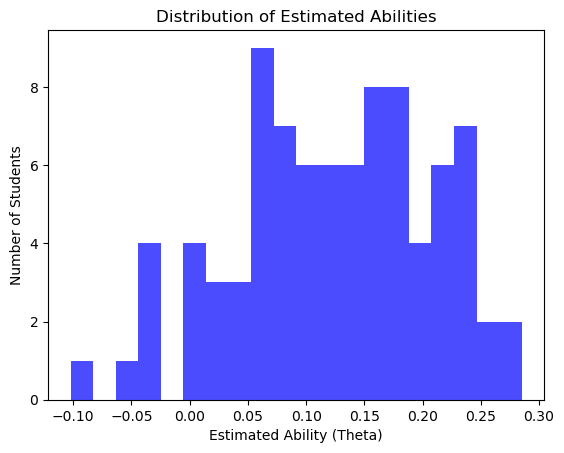

In [21]:
import numpy as np

# Function to compute the probability of a correct response given student's ability (theta)
def probability_correct(theta, a, b, c):
    """Calculate the probability of a correct response given ability (theta), discrimination (a), difficulty (b), and guessing (c)."""
    # Ensure stability by clamping the exponent within reasonable bounds
    exponent = np.clip(-a * (theta - b), -10, 10)
    return c + (1 - c) / (1 + np.exp(exponent))

# Function to estimate the ability (theta) using Maximum Likelihood Estimation (MLE)
def estimate_ability(response_vector, item_parameters, max_iterations=100, learning_rate=0.005, tolerance=1e-6):
    """Estimate the ability of a student using their response pattern and item parameters."""
    print("--------------- estimating ability----------------")
    
    print(response_vector)
    print(item_parameters)
    
    theta = 0  # Start with an initial guess of ability
    i=0
    for _ in range(max_iterations):
        gradient = 0
        hessian = 0
        
        # Calculate gradient and hessian for each item response
        for response, (a, b, c) in zip(response_vector, item_parameters):
            p_correct = probability_correct(theta, a, b, c)
            gradient += (response - p_correct) * (a)
            hessian += a * a * p_correct * (1 - p_correct)
            print(response, a, b, c, p_correct, gradient, hessian)
        
        # Update theta using gradient descent
        if abs(hessian) < tolerance:  # Prevent division by zero
            break
        theta_update = gradient / hessian
        # Clamp theta within a reasonable range to avoid divergence
        theta = np.clip(theta + learning_rate * theta_update, -5, 5)
        
        # Check for convergence
        if abs(theta_update) < tolerance:
            break
    print("theta:", theta)
    return theta

# Estimating abilities for each student using the updated approach
student_abilities = [estimate_ability(student_responses, item_parameters) for student_responses in responses]
print("Estimated Abilities:", student_abilities)

# Plotting the distribution of estimated abilities
import matplotlib.pyplot as plt

plt.hist(student_abilities, bins=20, color='blue', alpha=0.7)
plt.xlabel('Estimated Ability (Theta)')
plt.ylabel('Number of Students')
plt.title('Distribution of Estimated Abilities')
plt.show()


In [22]:
print("Estimated Abilities:", student_abilities)

Estimated Abilities: [0.2775594796903923, 0.08926258020136092, 0.05547972408749379, 0.14093172856980468, 0.13671645427860754, 0.1718606492024167, 0.1258888579477999, 0.11466457917058287, 0.034429299026462135, 0.18684475733192057, 0.16594713330324537, 0.10806801060537952, 0.06055440790025538, 0.1852170077274142, 0.2433979961725707, 0.10655604748363262, 0.18350406018127238, 0.20523753574651685, 0.19905066233396046, 0.007166755034492611, 0.26364095088334594, 0.010266974100100459, 0.12008349653995505, 0.0527438813051397, 0.08199193848491218, -0.049456645362333074, 0.0216964551966644, 0.2273037199238195, 0.09716344504713612, 0.06307965594508115, 0.21322955773449365, 0.11977638225721406, 0.1496943070337622, 0.1777136008883401, 0.06680435617922405, -0.003245667415489777, 0.1718606492024167, -0.03417508777768198, 0.171506263066075, 0.16375965424626876, 0.0843143854960386, 0.05983852179828509, 0.2264692415277345, 0.21159084289769833, 0.037144736193836535, 0.19312607456673622, 0.2189983306625883